In [1]:
from sklearn.decomposition import PCA
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
applicationPath = os.path.abspath("") + "/"
plt.style.use("https://raw.githubusercontent.com/dccote/Enseignement/master/SRC/dccote-errorbars.mplstyle")

In [3]:
def straightLine(X, m, b):
    return m*X + b

def curvefit(dataX, dataY, function):
        popt, pcov = curve_fit(function, dataX, dataY)
        nbPoint = len(dataX)
        newDataX = np.linspace(dataX[0], dataX[-1], nbPoint)
        newDataY = function(newDataX, *popt)
        perr = np.sqrt(np.diag(pcov))
        deltaValues = []
        for i in range(len(perr)):
            deltaValues.append(perr[i])
        return newDataX, newDataY, deltaValues, popt

def extractData(path, xPos, yPos, skip=0):
    fich = open(applicationPath + path, "r")
    fich_str = list(fich)[skip:]
    fich.close()
    x = []
    y = []
    for i in fich_str:
        elem_str = i.replace("\n", "")
        elem = elem_str.split(",")
        x.append(float(elem[xPos]))
        y.append(float(elem[yPos]))
    return {"x": x, "y": y}

def getCoefficientsWithPCA(data):
    pca = PCA(n_components=1)
    principalCoefficients = pca.fit_transform(data)
    principalComponents = np.array(pca.components_)
    inverse = np.linalg.pinv(principalComponents)
    moy = np.array(pca.mean_)
    m = moy@inverse
    coefs = principalCoefficients + m
    explainedVariance = pca.explained_variance_ratio_
    #print(sum(explainedVariance)) # value=0.9942653114936244
    coefficients = []
    for i in coefs:
        coefficients.append(i[0])
    coefficients = np.array(coefficients)
    return coefficients

## Extract data but only the interest region (around 1266 nm)

In [4]:
lamda = extractData("0%50ms.txt", 0, 1, 14).get("x")[39:76]
data0 = extractData("0%50ms.txt", 0, 1, 14).get("y")[39:76]
data2_5 = extractData("2,5%50ms.txt", 0, 1, 14).get("y")[39:76]
data7_5 = extractData("7,5%50ms.txt", 0, 1, 14).get("y")[39:76]
data10 = extractData("10%50ms2.txt", 0, 1, 14).get("y")[39:76]
data15 = extractData("15%50ms.txt", 0, 1, 14).get("y")[39:76]
data20 = extractData("20%50ms2.txt", 0, 1, 14).get("y")[39:76]
data_inconnu = extractData("TrucInconnu13%50ms.txt", 0, 1, 14).get("y")[39:76]

## PCA + linear curvefit to get an equation

In [5]:
datas = [data0, data2_5, data7_5, data10, data15, data20]
coefficients = getCoefficientsWithPCA(datas)
concentration = np.array([0, 2.5, 7.5, 10, 15, 20])
dataX, dataY, deltaValues, popt = curvefit(coefficients, concentration, straightLine)

## Guess (new PCA but with the unknown data)

In [6]:
datas.append(data_inconnu)
coefsInconnu = getCoefficientsWithPCA(datas)[-1]
concentrationFinale = straightLine(coefsInconnu, *popt)
print(round(concentrationFinale, 2), "%")

12.4 %


## Plots

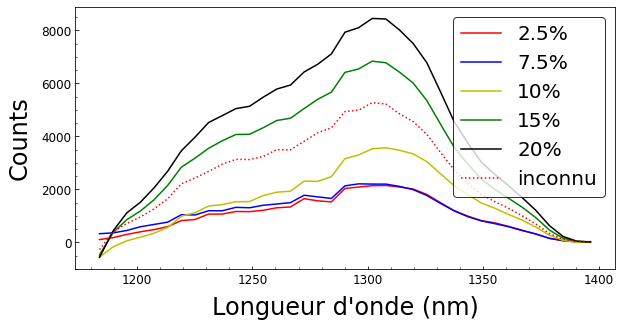

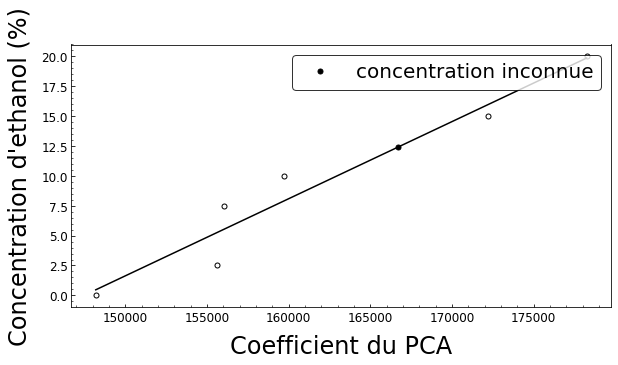

In [10]:
fig1, ax1 = plt.subplots(figsize=(10,5))
fig2, ax2 = plt.subplots(figsize=(10,5))

ax2.plot(coefficients, concentration, color="r", linestyle="", marker=".", markersize=10)
ax2.plot(dataX, dataY, color="k", linestyle="solid", marker="")
ax2.plot(coefsInconnu, concentrationFinale, color="k", marker=".", label="concentration inconnue", markersize=10, markerfacecolor='black')

ax1.plot(lamda, (np.array(data2_5)-np.array(data0))/(1), color="r", linestyle="solid", marker="", label="2.5%")
ax1.plot(lamda, (np.array(data7_5)-np.array(data0))/(1), color="b", linestyle="solid", marker="", label="7.5%")
ax1.plot(lamda, (np.array(data10)-np.array(data0))/(1), color="y", linestyle="solid", marker="", label="10%")
ax1.plot(lamda, (np.array(data15)-np.array(data0))/(1), color="g", linestyle="solid", marker="", label="15%")
ax1.plot(lamda, (np.array(data20)-np.array(data0))/(1), color="k", linestyle="solid", marker="", label="20%")
ax1.plot(lamda, (np.array(data_inconnu)-np.array(data0))/(1), color="r", linestyle="dotted", marker="", label="inconnu")

ax2.set_xlabel("Coefficient du PCA", fontsize=24)
ax2.set_ylabel("Concentration d'ethanol (%)", fontsize=24)
ax2.legend(loc=1, fontsize=20).set_draggable(state=True)

ax1.set_xlabel("Longueur d'onde (nm)", fontsize=24)
ax1.set_ylabel("Counts", fontsize=24)
ax1.legend(loc=1, fontsize=20).set_draggable(state=True)